In [3]:
!pip install scikit-learn-extra

  Using cached scikit-learn-extra-0.3.0.tar.gz (818 kB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-win_amd64.whl size=402401 sha256=c6a3c54905ad7e60b3b72a274b254991d3e905a96537cb30a6ba0cafe1ffbfcd
  Stored in directory: c:\users\hyemi\appdata\local\pip\cache\wheels\17\4d\c3\c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


time to start think the research question \
ex1. What are the main keywords in this journal, and how are they related? \
ex2. How have keyword trends in this journal changed over time? \
-> need to decide how to extract keyword. by word frequency? tf-idf? \
-> can the keyword be clustered? \
   or can we find clustering distribution of the articles then find keywords for each cluster?

In [2]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as numpy
import spacy

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st
import re

### textblob
from textblob import TextBlob

### countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

### tqdm
from tqdm import tqdm

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

In [3]:
import os
os.getcwd()

'C:\\Users\\OWNER\\TopicModeling'

In [3]:
# load the data
# ----------

df = pd.read_csv("articles_data.csv")
df_S = df[['Title','Abstract','Full Text']].dropna()
df.head()

,Title,Published Date,Type,Link,Authors,Abstract,Full Text
0,The inhibitory impact of collaboration on the ...,Oct,Original Research,https://www.frontiersin.org/journals/psycholog...,"Gongxiang Chen, Yuxuan Zhong, Sujie Li",The continued influence effect of misinformat...,The continued influence effect of misinformat...
1,RECALL prompting hierarchy improves responsive...,Oct,Original Research,https://www.frontiersin.org/journals/psycholog...,"Rebekah Bosley, Susan J. Loveall, Karen Kate K...",The purpose of the current study was to expand...,The purpose of the current study was to expand...
2,Assessing key soft skills in organizational co...,Oct,Original Research,https://www.frontiersin.org/journals/psycholog...,"Daiana Colledani, Egidio Robusto, Pasquale Ans...","Soft skills, also known as transversal skills,...","Introduction: Soft skills, also known as trans..."
3,Mapping perceived sentiments in university cam...,Oct,Original Research,https://www.frontiersin.org/journals/psycholog...,"Qiyuan Yan, Yuxiang Sun",A sustainable university campus should accommo...,A sustainable university campus should accommo...
4,The impact of job stress on job satisfaction a...,Oct,Original Research,https://www.frontiersin.org/journals/psycholog...,"Mei-Hui Lin, Ya-Hui Yen, Tsai-Fu Chuang, Ping-...",The main objective of this study is to explore...,Objective: The main objective of this study is...


In [7]:
# tokenize

###' ################################################################################
###'
###' Function for Deleteing Punctuations and StopWords
###'
###'

### define fuction
def rem_punc_stop(text):
    # When text is None
    if text is None:
        return []

    # Convert text to lowercase
    text = text.lower()

    # Define additional stop words
    stop_words = STOP_WORDS | {"abstract", "available", "student", "research", "study", "impact", "effect",
                               "result", "al", "et", "doi", "googlescholar", "google", "scholar", "textgoogle", 
                               "full", "crossref", "introduction", "background", "purpose" "aim", "objective","use","child"}
    # Define punctuation
    punc = set(punctuation)

    # Remove punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])

    # Apply NLP processing
    doc = nlp(punc_free)

    # Tokenize and lemmatize
    text_lemma = " ".join([token.lemma_ for token in doc])

    # Filter tokens to remove URLs, stop words, and non-alphabetic tokens
    filtered_tokens = [word for word in text_lemma.split() if word not in stop_words and word.isalpha()]

    # Return filtered tokens for TfidfVectorizer
    return filtered_tokens
    

###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

### sample from the whole dataset
df_S['Title_tokens'] = df_S['Title'].map(lambda x: rem_punc_stop(x))
df_S['Title_join'] = df_S['Title_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")

df_S['Abstract_tokens'] = df_S['Abstract'].map(lambda x: rem_punc_stop(x))
df_S['Abstract_join'] = df_S['Abstract_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


df_S['Full_tokens'] = df_S['Full Text'].map(lambda x: rem_punc_stop(x))
df_S['Full_join'] = df_S['Full_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


###' ################################################################################
###'
###' Filter Yet Published Papers
###'
###'

df_S['Full_count'] = df_S['Full Text'].dropna().apply(lambda x: len(str(x).split()))
df_S = df_S[df_S['Full_count'] >= 2000]

df_S

NameError: name 'df_S' is not defined

# 3. TF-IDF

In [5]:
len(df_S)

149

In [28]:
X = df_24_S['Full Text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()
dense_matrix

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.02404609, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.17522704, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [29]:
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(),       # convert to array than to datafram
                        columns=tf.get_feature_names_out())
# sort by term frequency on the first document
tfidf_df.T.nlargest(10,  # transpose the matrix = columns become documents and rows are words
                     0)  # on column index 0 to show the largest

,0,1,2,3,4,5,6,7,8,9,...,545,546,547,548,549,550,551,552,553,554
class,0.473139,0.000000,0.0,0.000000,0.007837,0.000000,0.107902,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.023036,0.000000,0.000000,0.008846,0.003353,0.0,0.000000
envy,0.384653,0.005308,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
stereotype,0.351456,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.003904,0.020943,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.012205
mobility,0.297286,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
intergroup,0.265072,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
upward,0.231638,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
lowerclass,0.231226,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
competence,0.223369,0.000000,0.0,0.002068,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.016236,0.009685,0.000000,0.0,0.000000
conflict,0.164842,0.000000,0.0,0.000000,0.000000,0.004436,0.000000,0.0,0.035703,0.000000,...,0.001723,0.0,0.000000,0.005911,0.003681,0.000000,0.000000,0.030970,0.0,0.000000
upper,0.140894,0.000000,0.0,0.000000,0.003854,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.004605,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


# 3.1 Clustering

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.32it/s]


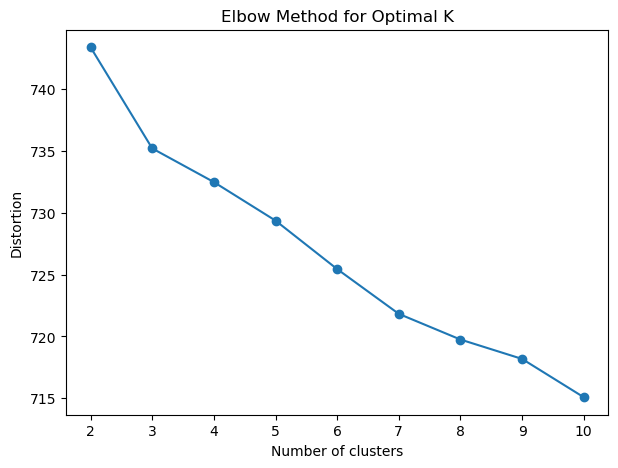

In [30]:
distortions = []
for i in tqdm(range(2, 11)):
    kmedoids = KMedoids(n_clusters=i, random_state=42).fit(tfidf_matrix)
    #inertia가 군집 내의 분산을 의미
    distortions.append(kmedoids.inertia_)

# plot
plt.figure(figsize=(7,5))
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

### 4 > 6

In [31]:
#
# determining optional k: silhouette scores
# ------------------------------
# define a number of functions

# iterate over a k-means fits to have different clusters
# ---------
def run_KMedoids(max_k, data):
    max_k += 1
    kmedoids_results = dict()
    for k in range(2 , max_k):
        kmedoids = KMedoids(n_clusters=k,
                            random_state=42)
        kmedoids_results.update( {k : kmedoids.fit(data)} )
        
    return kmedoids_results


# calculate average silhouettes scores 
# ---------
# plot silhouettes scores
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))

# plot silhouettes scores       
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg): 
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])   # play with this to set x-axis limits
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(numpy.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
# put it altogether
def silhouette(kmeans_dict, df, plot=True):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

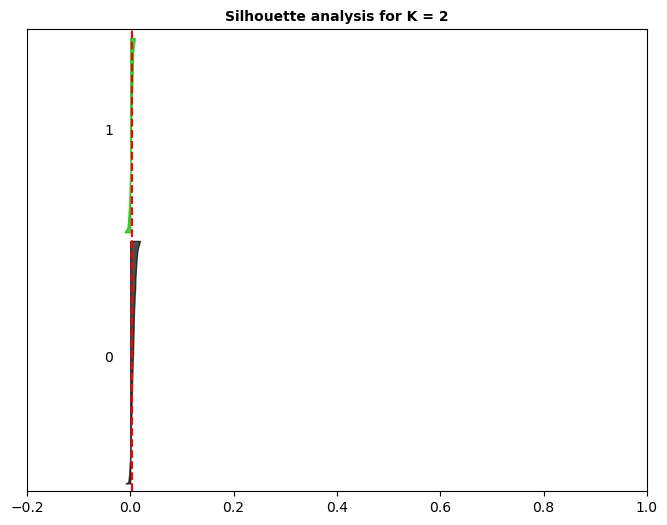

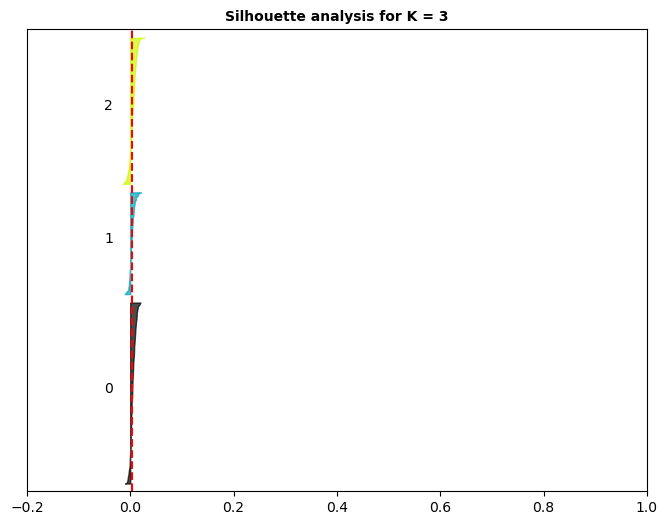

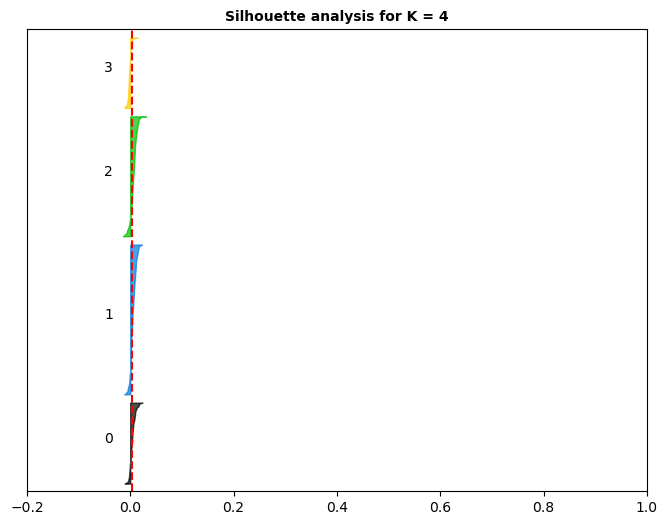

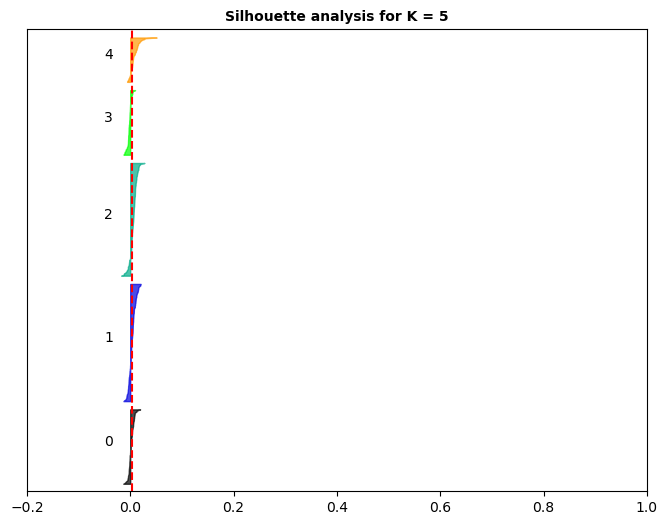

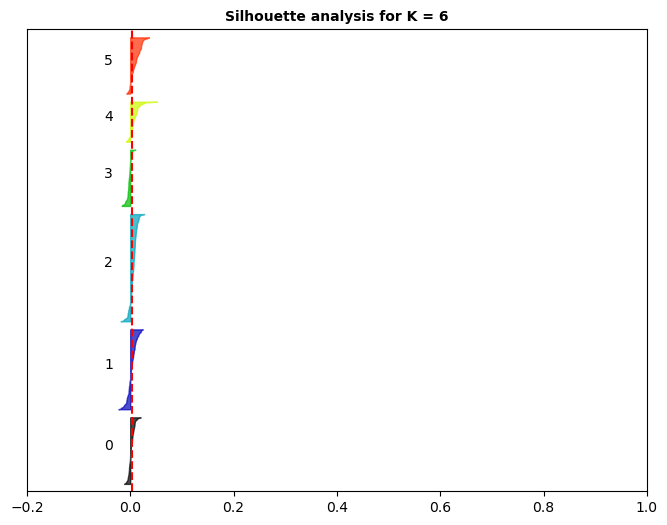

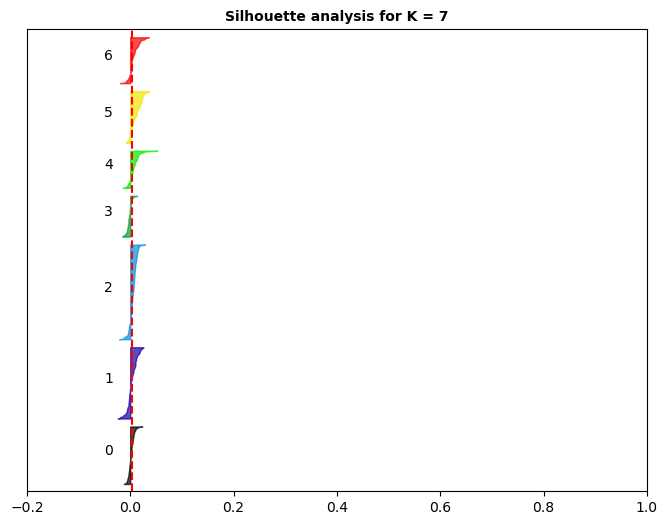

In [32]:
k = 7 # choose 8 based on the elbow method result from above

# run the k-means algorithm
kmedoids_results = run_KMedoids(k, data = tfidf_df) 

# plot the silhouette analysis
silhouette(kmedoids_results, tfidf_df) 

In [33]:
# get the top features from each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = numpy.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = numpy.where(prediction==label) # indices for each cluster
        x_means = numpy.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = numpy.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

# plot them on a barplot
def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

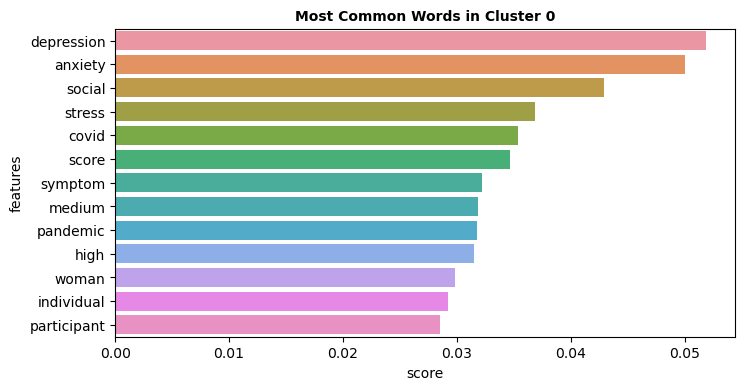

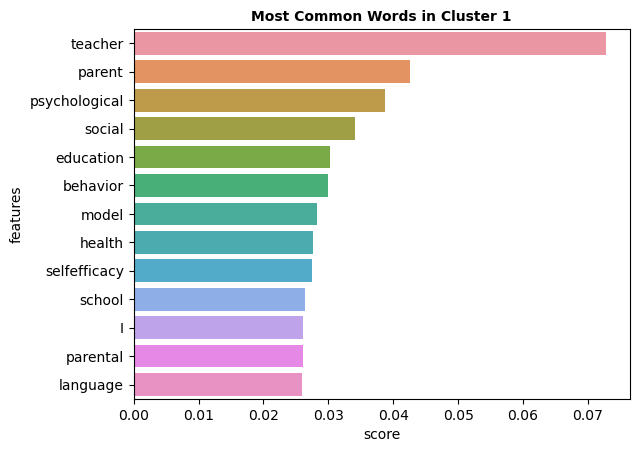

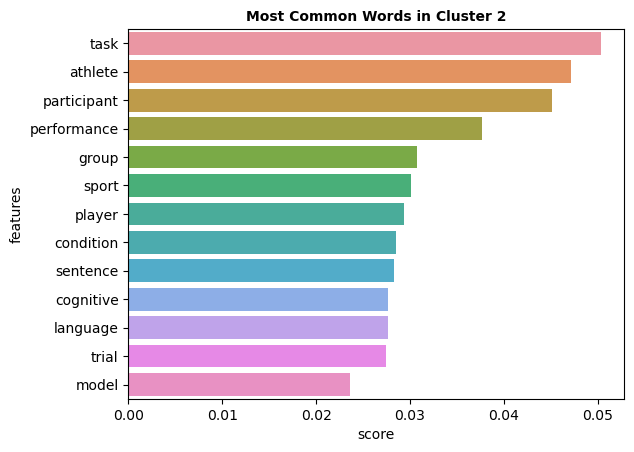

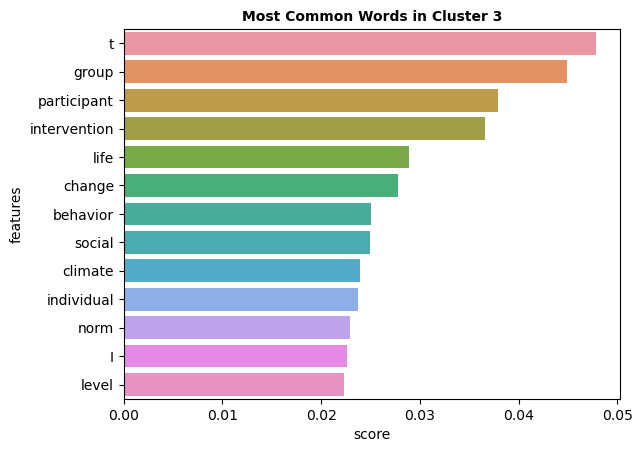

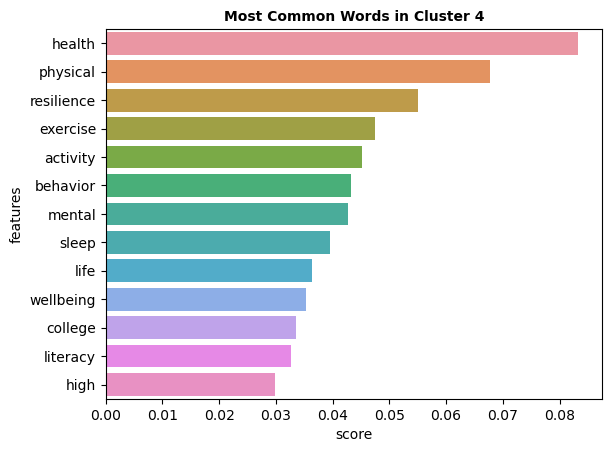

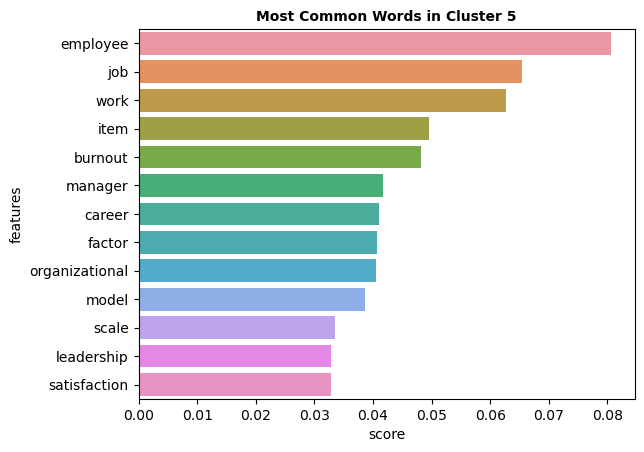

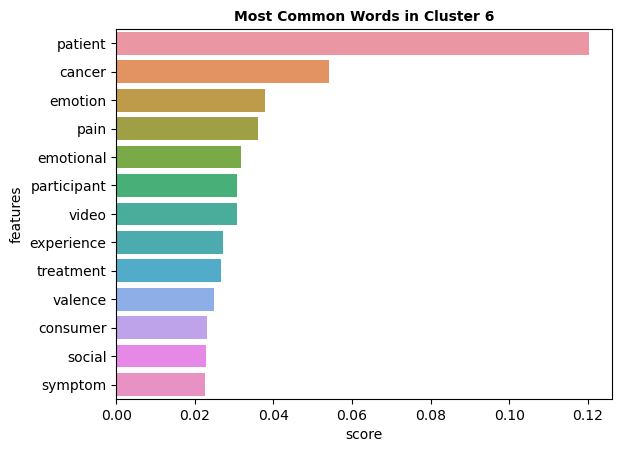

In [35]:
best_result = 7
kmedoids = kmedoids_results.get(best_result)

# processing for plot
tfidf_array = tfidf_df.to_numpy()     # convert dataframe to array
prediction = kmedoids.predict(tfidf_df) # predict cluster using tf-idf dataframe


# plot
n_feats = 20
dfs = get_top_features_cluster(tfidf_array, # specify dataset which is an array
                               prediction,  # make specify prediciton
                               n_feats )    # set number of features 
plotWords(dfs, # specify data for plotting  
          13)  # set number of features

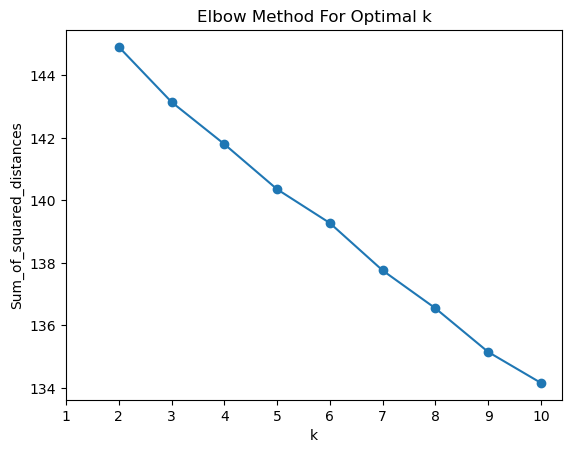

In [42]:
inertia = []

K = range(2, 11) 
for k in K:
    km = KMeans(n_clusters=k,
                random_state=42, # number of clusters
                init='k-means++', # method for initalization 
                n_init=10)     # number of times the k-means algorithm is run with different centroid seeds
    km.fit(tfidf_matrix)     # fit
    inertia.append(km.inertia_) # pipe inertia calculations into list


# plot results
# ---------
plt.plot(K, inertia, marker='o')
plt.xlabel('k')
plt.xticks(range(1, max(K) + 1, 1))
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### 7 or 9

In [43]:
#
# determining optional k: silhouette scores
# ------------------------------
# define a number of functions

# iterate over a k-means fits to have different clusters
# ---------
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , random_state = 42)

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results


# calculate average silhouettes scores 
# ---------
# plot silhouettes scores
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))

# plot silhouettes scores       
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg): 
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])   # play with this to set x-axis limits
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(numpy.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
# put it altogether
def silhouette(kmeans_dict, df, plot=True):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

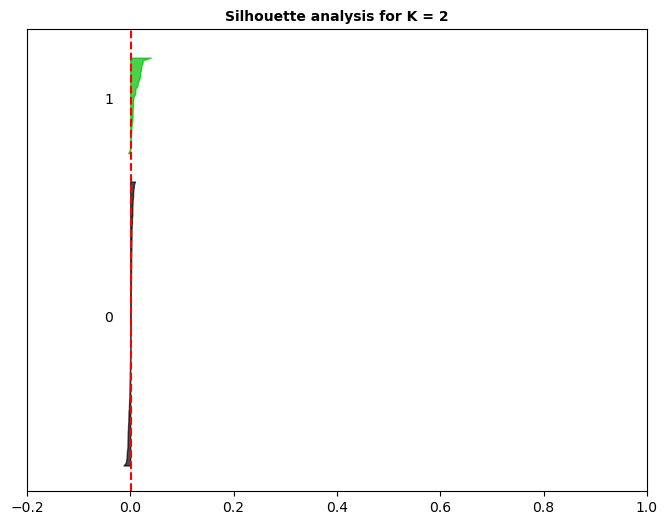

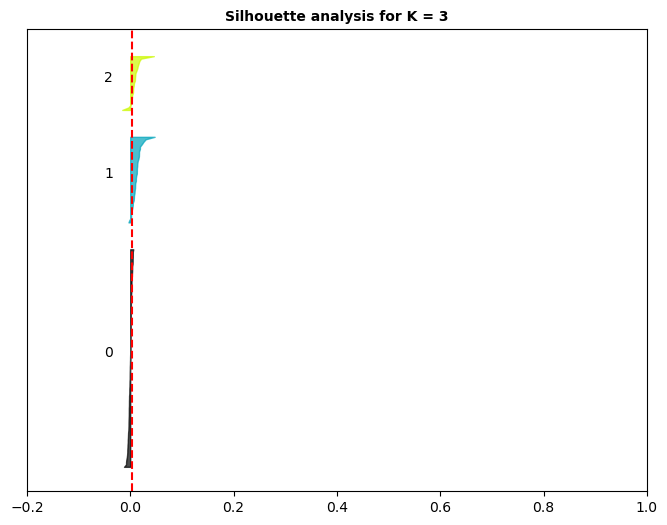

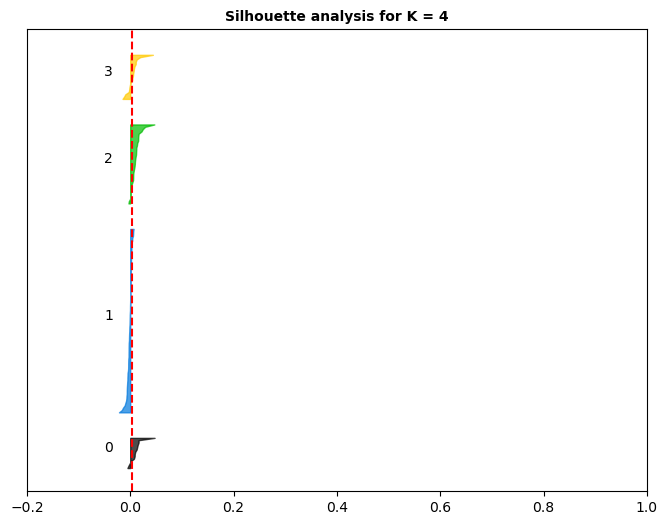

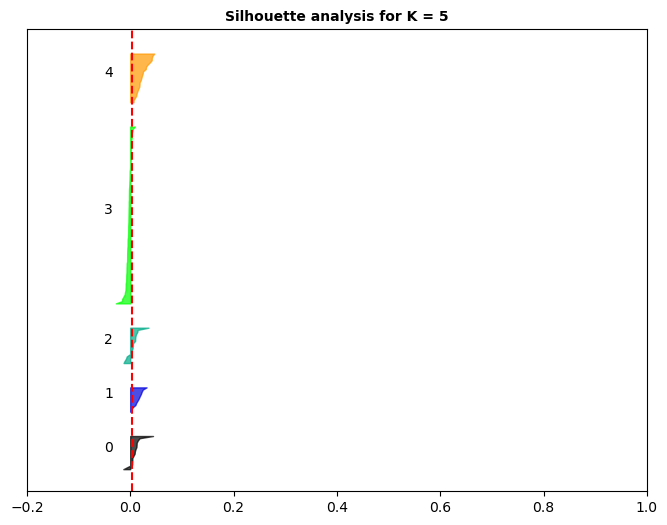

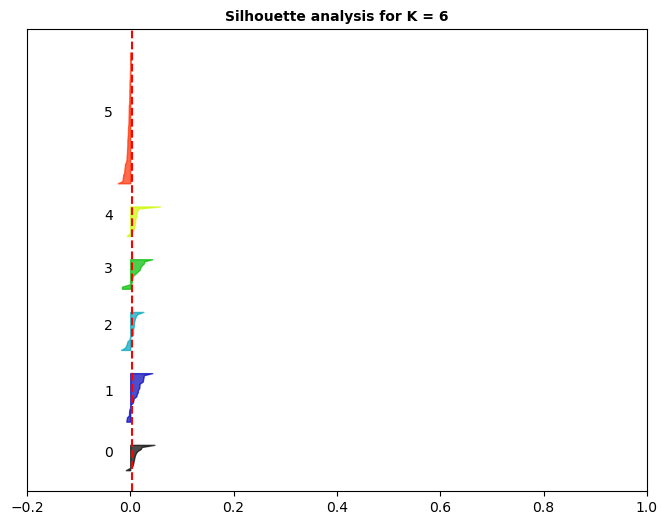

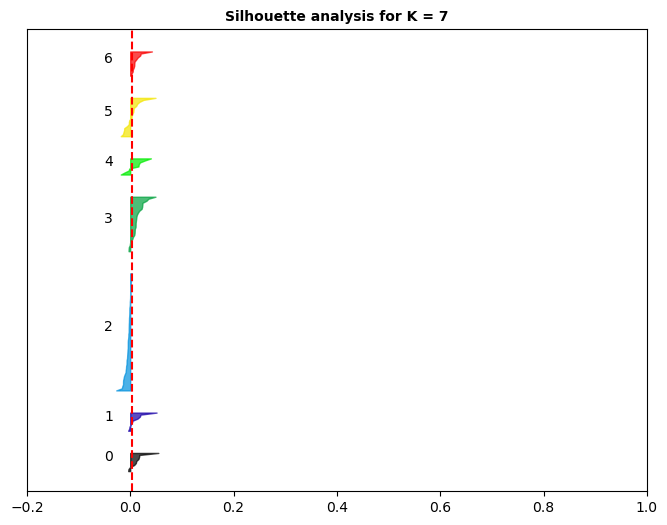

In [46]:
k = 7 # choose 8 based on the elbow method result from above

# run the k-means algorithm
kmeans_results = run_KMeans(k,                # set k
                            data = tfidf_df)  # identify data


# plot the silhouette analysis
silhouette(kmeans_results,     # take k-means results
           tfidf_df) 

In [47]:
# get the top features from each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = numpy.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = numpy.where(prediction==label) # indices for each cluster
        x_means = numpy.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = numpy.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

# plot them on a barplot
def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

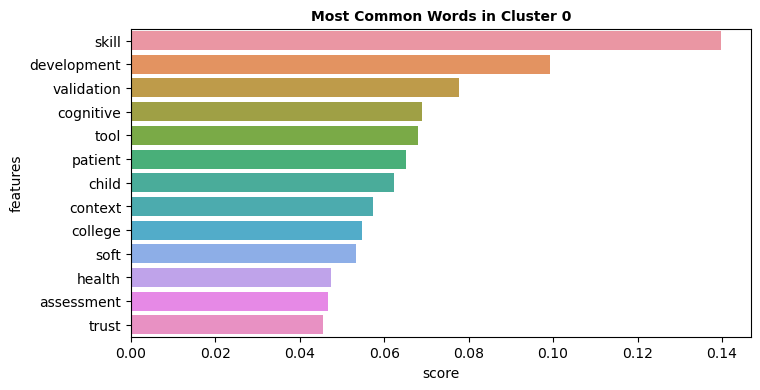

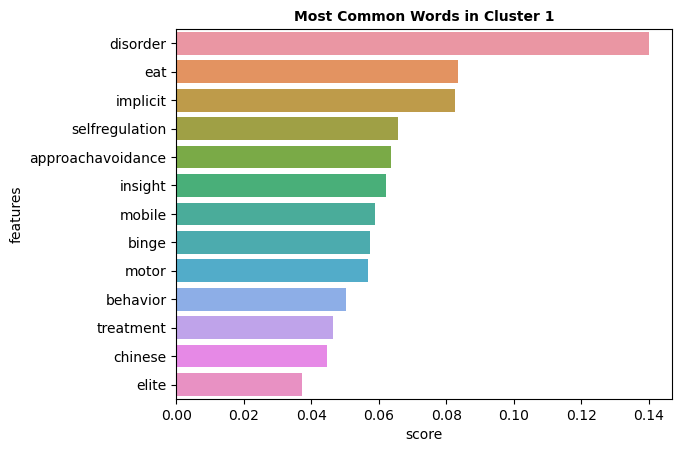

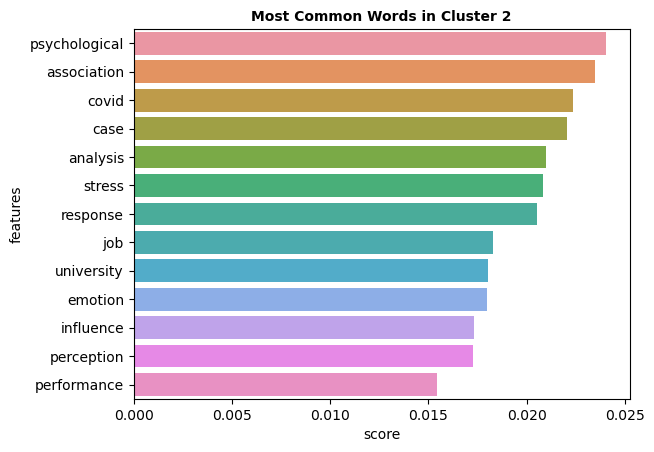

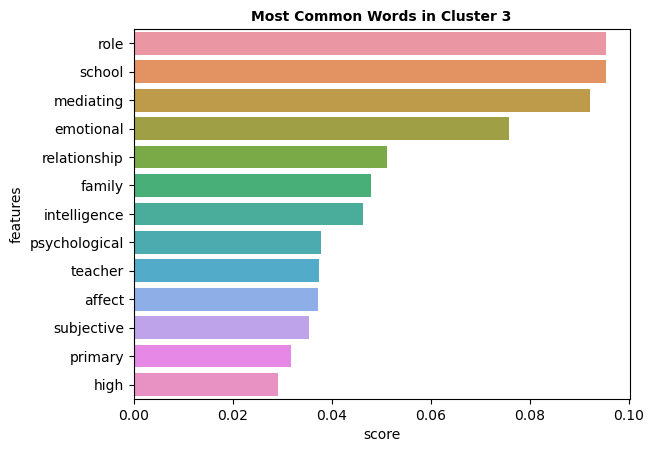

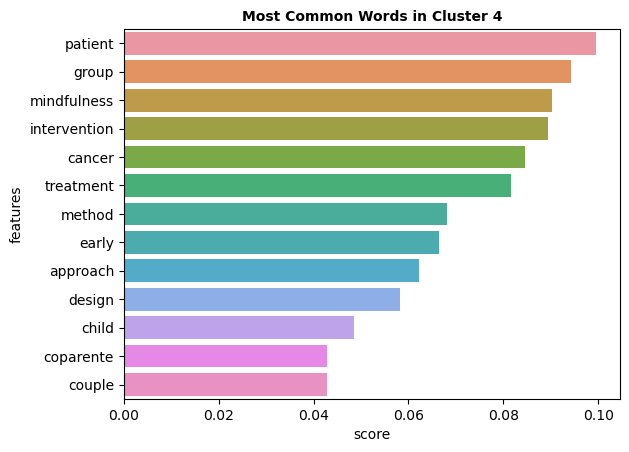

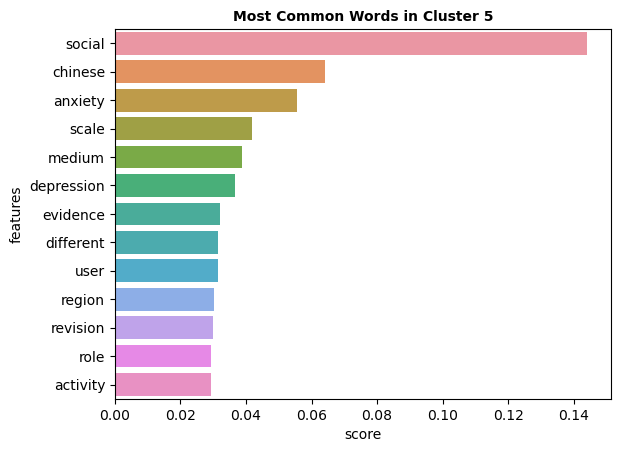

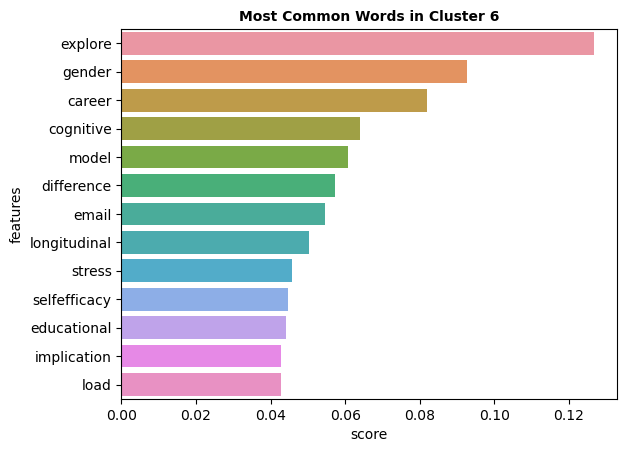

In [48]:
best_result = 7
kmeans = kmeans_results.get(best_result)

# processing for plot
tfidf_array = tfidf_df.to_numpy()     # convert dataframe to array
prediction = kmeans.predict(tfidf_df) # predict cluster using tf-idf dataframe


# plot
n_feats = 20
dfs = get_top_features_cluster(tfidf_array, # specify dataset which is an array
                               prediction,  # make specify prediciton
                               n_feats )    # set number of features 
plotWords(dfs, # specify data for plotting  
          13)  # set number of features

# 3.2 Latent Dirichlet Allocation (LDA)

In [49]:
###' ################################################################################
###'
###' Topic Modeling : Latent Dirichlet Allocation (LDA)
###'
###'


### define function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nlda_{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    

In [50]:
#
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = df_S['Title_join']
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=7, # specify the number of components
                                max_iter=20,    # specify the number of iterations 
                                random_state=42) # set a seed for reproducibility

# fit LDA model to our dense matrix
lda = lda.fit(numpy.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(lda,               # specify model
                tf_feature_names,  # specify feature names vector
                20)                # specify how many words we want to see
 

# now transform our data using the lda model and create a dataframe
col_names = ['lda_0', 'lda_1','lda_2', 'lda_3','lda_4','lda_5', 'lda_6']
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist, columns = col_names).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
topic_dist_df


lda_0:
virtual cognitive psychological mix method education disorder gender inpatient long mechanism influence management soft operational reality tool approach collaboration inhibitory

lda_1:
mindfulness role anxiety mobile online mediating behavior teacher subjective school homework perceive longitudinal eat quality sleep academic parental stress motivation

lda_2:
mental development role social scale communicate chain chinese function revision inference environment mediate health perceive university relationship adolescent competitive response

lda_3:
school association level emotion chinese dietary child high risk educational forest problem adult use learn activity father inter pare primus

lda_4:
emotional role psychological work relationship wellbee experience explore university healthcare intelligence email year performance commitment engagement approach I primary motor

lda_5:
family math chinese stress resilience achievement cognitive adolescent mediate longitudinal strategy

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6
0,0.733554,0.044409,0.044415,0.044411,0.044423,0.044397,0.044390
1,0.799220,0.033435,0.033463,0.033492,0.033423,0.033519,0.033448
2,0.792332,0.034593,0.034717,0.034575,0.034567,0.034609,0.034607
3,0.034474,0.034527,0.034526,0.034484,0.793060,0.034464,0.034465
4,0.036635,0.036689,0.036581,0.036648,0.036610,0.780252,0.036585
...,...,...,...,...,...,...,...
144,0.039277,0.039288,0.764371,0.039282,0.039261,0.039260,0.039261
145,0.033261,0.800293,0.033270,0.033258,0.033269,0.033361,0.033289
146,0.031248,0.031296,0.031328,0.031299,0.031359,0.031243,0.812226
147,0.034603,0.034503,0.034531,0.034487,0.034527,0.792856,0.034493


In [31]:
df_w_topics = df_S.join(topic_dist_df.reset_index())
df_w_topics.head(5)

,Title,Abstract,Full Text,Title_tokens,Title_join,Abstract_tokens,Abstract_join,Full_tokens,Full_join,Full_count,index,lda_0,lda_1
0,The inhibitory impact of collaboration on the ...,The continued influence effect of misinformat...,The continued influence effect of misinformat...,"[inhibitory, collaboration, continue, influenc...",inhibitory collaboration continue influence mi...,"[continue, influence, misinformation, refer, p...",continue influence misinformation refer persis...,"[continue, influence, misinformation, refer, p...",continue influence misinformation refer persis...,6909,0.0,0.937747,0.062253
1,RECALL prompting hierarchy improves responsive...,The purpose of the current study was to expand...,The purpose of the current study was to expand...,"[recall, prompt, hierarchy, improve, responsiv...",recall prompt hierarchy improve responsiveness...,"[purpose, current, expand, previous, recall, d...",purpose current expand previous recall dialogi...,"[purpose, current, expand, previous, recall, d...",purpose current expand previous recall dialogi...,6970,1.0,0.952620,0.047380
2,Assessing key soft skills in organizational co...,"Soft skills, also known as transversal skills,...","Introduction: Soft skills, also known as trans...","[assess, key, soft, skill, organizational, con...",assess key soft skill organizational context d...,"[soft, skill, know, transversal, skill, gain, ...",soft skill know transversal skill gain signifi...,"[soft, skill, know, transversal, skill, gain, ...",soft skill know transversal skill gain signifi...,5729,2.0,0.958957,0.041043
3,Mapping perceived sentiments in university cam...,A sustainable university campus should accommo...,A sustainable university campus should accommo...,"[mapping, perceive, sentiment, university, cam...",mapping perceive sentiment university campus v...,"[sustainable, university, campus, accommodate,...",sustainable university campus accommodate expe...,"[sustainable, university, campus, accommodate,...",sustainable university campus accommodate expe...,6180,3.0,0.949111,0.050889
4,The impact of job stress on job satisfaction a...,The main objective of this study is to explore...,Objective: The main objective of this study is...,"[job, stress, job, satisfaction, turnover, int...",job stress job satisfaction turnover intention...,"[main, explore, relationship, job, stress, job...",main explore relationship job stress job satis...,"[main, explore, relationship, job, stress, job...",main explore relationship job stress job satis...,6940,4.0,0.932150,0.067850


# 3.3 Non-Negative Matrix Factorization (NMF)

In [51]:
###' ################################################################################
###'
###' Topic Modeling : on-Negative Matrix Factorization (NMF)
###'
###'


### define function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nnmf_{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
    
# pre-processing
Y = df_S['Abstract_join']

tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None) 

tfidf_mx =  tf.fit_transform(Y)
dense_matrix = tfidf_mx.todense()


# initialize LDA and set model parameters
nmf = NMF(n_components=7,  # specify the number of components
          init='random',   # specify the initalization method
          random_state=42)  # set a seed for reproducibility

# fit NMF model to our dense matrix
nmf = nmf.fit(numpy.asarray(dense_matrix))

# post-processing
tf_feature_names = tf.get_feature_names_out()

In [52]:
### print top words 
print_top_words(nmf, tf_feature_names,20)  

### join
col_names2 = ['nmf_0', 'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4', 'nmf_5', 'nmf_6']
topic_dist2 = nmf.transform(tfidf_mx)
topic_dist_nmf = pd.DataFrame(topic_dist2, columns = col_names2).reset_index(drop = True)
topic_dist_nmf

#df_w_topics2 = topic_dist_df.join(topic_dist_nmf.reset_index())
#df_w_topics2.head(5)


nmf_0:
child response intervention father school use group math level language primary cer story experience interventionist problem transition comprehension baseline educational

nmf_1:
school teacher psychological relationship role job career stress resilience explore wellbeing family mediate emotional performance parenting wellbee professional education need

nmf_2:
health mental covid population chinese campus affect space green know disaster greenness usually doctoral event long youth dietary addiction pathway

nmf_3:
social anxiety user medium behavior identity scale motivation sleep misinformation individual examine investigate commerce adolescent factor infant friend covid homework

nmf_4:
treatment depression patient cancer disorder therapy medical cd subthreshold intervention binge eat adolescent psychological lung life experience breast limit eg

nmf_5:
cognitive learn word process performance emotion hand visual read control participant old environmental experiment human ab

,nmf_0,nmf_1,nmf_2,nmf_3,nmf_4,nmf_5,nmf_6
0,0.000000,0.000000,0.000000,0.031838,0.000000,0.033646,0.001875
1,0.194147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240967
3,0.000000,0.004299,0.082740,0.000000,0.000000,0.005189,0.005279
4,0.000000,0.103704,0.033193,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
144,0.000000,0.000000,0.014057,0.007385,0.000000,0.047871,0.000000
145,0.000000,0.118328,0.000000,0.000000,0.000000,0.000000,0.000736
146,0.000000,0.000000,0.102040,0.002532,0.006424,0.000411,0.000000
147,0.000000,0.000000,0.000000,0.000000,0.000000,0.054199,0.066680
